In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage.filters import laplace
from skimage import feature
from itertools import chain
import random

from load import *

#plt.rcParams['figure.figsize'] = (16, 16)

In [2]:
class TestSet: 
    """Stores test set or validation set data and images.
    
    self.data   = list of 3D image arrays with dimensions (stack, time, w, h)
    self.labels = list of 3D ROI arrays with dimensions (stack, ROI index, w, h)
    Change code so "files" points to the test/validation set
    """
    def __init__(self):
        files = []
        for j in range(3,5):
            prefix = '../data/AMG3_exp%d'%(j)
            files.append( (prefix+'.tif', prefix+'.zip') )
        self.data = []
        self.labels = []
        for i,(s,r) in enumerate(files):
            self.data.append(load_stack(s))
            self.labels.append(load_rois(r, 512, 512))

class Score:
    """Class to calculate and store score.
    
    Constructor takes a prediction function that takes a list of image stacks and 
    returns a list of 3D 0-1 ROI arrays with dimensions (stack, roi index, w, h).
    
    self.predictions      = list of predicted ROIs (stack, ROI index, w, h)
    self.categorized      = list of predicted ROIs divided into FPs, FNs, and TPs matched with true ROIs
                             pred ROIs with <0.5 overlap to any true ROI are false positives
                             true ROIs with <0.5 overlap to any pred ROI are false negatives
                             true positive pairs are made by maximizing overlap between pairs
                             e.g. self.categorized[0]["fps"][n] = nth false positive ROI from the 0th image stack
                             e.g. self.categorized[0]["tps"][n] = nth (pred ROI, true ROI) pair from 0th image stack
    self.total_f1_score   = F1 score with all image stacks merged
    self.f1_scores        = list of F1 scores per stack
    self.total_precision  = total precision with all image stacks merged
    self.precisions       = list of precisions per stack
    self.total_recall     = total recall with all stacks merged
    self.recalls          = list of recalls per stack
    self.total_overlap_bq = dict of pixel-wise precisions and recalls for all paired TP predicted ROIs and true ROIs
                            keys = ["mean precision", "std precision", "mean recall", "std recall"]
                             e.g. self.total_overlap_bq["mean precision"] = 
                               mean (pixels in both pred_roi and true_roi) / (pixels in pred_roi)
    self.overlap_bqs      = list of dicts as in self.total_overlap_bq with one dict per image stack                   
    """
    def __init__(self, prediction_func):
        test_set = TestSet()
        self.predictions = prediction_func(test_set.data)
        # assert that predicted and true ROI stacks are the same shape
        assert(all([self.predictions[i].shape[1] == test_set.labels[i].shape[1] 
                    for i in range(len(test_set.labels))]))
        # assert that predicted ROI stacks are 0-1 arrays
        assert(all([np.all(np.logical_or(self.predictions[i] == 1, self.predictions[i] == 0)) 
                    for i in range(len(self.predictions))]))
        self.categorized = categorize(self.predictions, test_set.labels)
        self.precisions, self.total_precision, self.recalls, self.total_recall = calc_precision_recall(self.categorized)
        self.f1_scores = map(calc_f1_score, zip(self.precisions, self.recalls))
        self.total_f1_score = calc_f1_score((self.total_precision, self.total_recall))
        self.overlap_bqs, self.total_overlap_bq = overlap_boundary_quality(self.categorized)
       
    def __str__(self):
        """Convert Score to readable output"""
        string =  "Total F1 Score      = {}\n".format(self.total_f1_score)
        string += "F1 Score per stack  = {!s}\n".format(self.f1_scores)
        string += "Total Precision     = {}\n".format(self.total_precision)
        string += "Precision per stack = {!s}\n".format(self.precisions)
        string += "Total Recall        = {}\n".format(self.total_recall)
        string += "Recall per stack    = {!s}\n".format(self.recalls)
        string += "Overlap Boundary Quality, all stacks = {!s}\n".format(self.total_overlap_bq)
        string += "Overlap Boundary Quality, per stack  = {!s}\n\n".format(self.overlap_bqs)
        return string
    
    def plot(self):
        """Plot all data in Score"""
        fig, ax = plt.subplots()
        yvals = [self.total_f1_score, self.total_precision, self.total_recall, 
                self.total_overlap_bq["mean precision"], self.total_overlap_bq["std precision"],
                self.total_overlap_bq["mean recall"], self.total_overlap_bq["std recall"]]
        xvals = np.arange(len(yvals))
        plt.bar(xvals, yvals, width=0.6)
        ax.set_xticks(xvals + 0.3)
        ax.set_xticklabels(['F1 score', 'precision', 'recall', 'mbp', 'sbp', 'mbr', 'sbr'])
        plt.show()
        
def categorize(predictions, labels):
    "Divide predictions and labels into FPs, FNs, and TPs"
    categorized = []
    for i in range(len(predictions)):
        categorized.append({"fps":[], "fns":[], "tps":[]})
        rois_pred, rois_true = list(predictions[i].copy()), list(labels[i].copy())
        for roi_pred in rois_pred:
            overlaps = map(lambda roi_true: calc_overlap(roi_pred, roi_true)[0], rois_true)
            best_overlap, best_index = np.max(overlaps), np.argmax(overlaps)
            if best_overlap > 0.5:
                categorized[i]["tps"].append((roi_pred, rois_true[best_index]))
                del rois_true[best_index]
            else:
                categorized[i]["fps"].append(roi_pred)
        for roi_true in rois_true:
            categorized[i]["fns"].append(roi_true)
    return categorized

def calc_precision_recall(categorized):
    """Calculate precision and recall from categorized predictions and labels"""
    num_fps = [len(categorized[i]["fps"]) for i in range(len(categorized))]
    num_fns = [len(categorized[i]["fns"]) for i in range(len(categorized))]
    num_pairs = [len(categorized[i]["tps"]) for i in range(len(categorized))]
    precisions = [num_pairs[i] / float(num_pairs[i] + num_fps[i]) for i in range(len(categorized))]
    recalls = [num_pairs[i] / float(num_pairs[i] + num_fns[i]) for i in range(len(categorized))]
    total_precision = sum(num_pairs) / float(sum(num_pairs) + sum(num_fps))
    total_recall = sum(num_pairs) / float(sum(num_pairs) + sum(num_fns))
    return precisions, total_precision, recalls, total_recall
    
def calc_overlap(roi_pred, roi_true):
    """For a given (2D array, 2D array) pair of predicted and true ROIs,
    overlap   = (# pixel intersection / (# pixel union)
    precision = (# pixel intersection) / (# pixels in true ROI)
    recall    = (# pixel interection) / (# pixels in pred ROI)
    """
    intersection = np.sum(np.logical_and(roi_pred, roi_true))
    union = np.sum(np.logical_or(roi_pred, roi_true))
    if union == 0: 
        return 0, 0, 0
    precision = intersection / float(np.sum(roi_pred))
    recall = intersection / float(np.sum(roi_true))
    overlap = intersection / float(union)
    return overlap, precision, recall

def calc_f1_score((precision, recall)):
    """F1 score is harmonic mean of precision and recall"""
    if recall == 0:
        return 0 
    else:
        return (2 * precision * recall) / (precision + recall)
    
def overlap_boundary_quality(categorized):
    """Calculates pixel-based mean and std of precision and recall 
    of TP (pred roi, true roi) pairs
    """
    qualities = []
    precisions = []
    recalls = []
    for i in range(len(categorized)):
        precisions.append([])
        recalls.append([])
        for roi_pred, roi_true in categorized[i]["tps"]:
            _, precision, recall = calc_overlap(roi_pred, roi_true)
            precisions[i].append(precision)
            recalls[i].append(recall)
        qualities.append({"mean precision": np.mean(precisions[i]), "std precision": np.std(precisions[i]),
                          "mean recall": np.mean(recalls[i]), "std recall": np.std(recalls[i])})
    overall = {"mean precision": np.mean(list(chain.from_iterable(precisions))),
               "std precision": np.std(list(chain.from_iterable(precisions))),
               "mean recall": np.mean(list(chain.from_iterable(recalls))),
               "std recall": np.std(list(chain.from_iterable(recalls)))}
    return qualities, overall   

In [3]:
def plot_multiple_scores(scores):
    """Takes list of multiple scores and plots precision/recall curves
    and f1 score comparisons.
    """
    f1_fig, ax = plt.subplots()
    f1s = [s.total_f1_score for s in scores]
    x = np.arange(len(f1s))
    plt.bar(x, f1s, width=1)
    ax.set_xticks(x + 0.5)
    ax.set_xticklabels(map(str,x))
    plt.ylabel('F1 score')
    plt.xlabel('Algorithm Number')
    
    pr_fig = plt.figure()
    recalls = [s.total_recall for s in scores]
    precisions = [s.total_precision for s in scores]
    r, p, num = zip(*sorted(zip(recalls, precisions, np.arange(len(recalls)))))
    plt.plot(r, p, '.-', markersize=10)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    print "Score Number in order of increasing recall: " + str(num)
    
    pr_boundary_fig = plt.figure()
    recalls = [s.total_overlap_bq["mean recall"] for s in scores]
    precisions = [s.total_overlap_bq["mean precision"] for s in scores]
    r_std = [s.total_overlap_bq["std recall"] for s in scores]
    p_std = [s.total_overlap_bq["std precision"] for s in scores]
    rm, pm, rs, ps, num = zip(*sorted(zip(recalls, precisions, r_std, p_std, np.arange(len(recalls)))))
    print pm
    print rm
    plt.errorbar(rm, pm, xerr=rs, yerr=ps, fmt='.-',markersize=10)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    print "Score number in order of increasing boundary recall: " + str(num)
    
    plt.show()

In [5]:
"""TESTING AND EXAMPLE CODE BELOW"""
t = TestSet()
def predict_perfect(data):
    return t.labels
def predict_shift_3(data):
    return shift_rois(t.labels, 3)
def predict_shift_5(data): 
    return shift_rois(t.labels,5)
def predict_shift_15(data):
    return shift_rois(t.labels,15)   
            
def shift_rois(labels, shift_amt):
    new_labels = []
    for stack in labels:
        new_stack = np.zeros(stack.shape)
        for i,roi in enumerate(stack):
            new_stack[i] = np.roll(roi, shift_amt, axis=1)
        new_labels.append(new_stack)
    return new_labels

scores = [Score(predict_perfect), Score(predict_shift_3), 
          Score(predict_shift_5), Score(predict_shift_15)]


In [6]:
for s in scores:
    print str(s)


Total F1 Score      = 1.0
F1 Score per stack  = [1.0, 1.0]
Total Precision     = 1.0
Precision per stack = [1.0, 1.0]
Total Recall        = 1.0
Recall per stack    = [1.0, 1.0]
Overlap Boundary Quality, all stacks = {'std recall': 0.0, 'mean precision': 1.0, 'std precision': 0.0, 'mean recall': 1.0}
Overlap Boundary Quality, per stack  = [{'std recall': 0.0, 'mean precision': 1.0, 'std precision': 0.0, 'mean recall': 1.0}, {'std recall': 0.0, 'mean precision': 1.0, 'std precision': 0.0, 'mean recall': 1.0}]


Total F1 Score      = 0.992337164751
F1 Score per stack  = [0.9896907216494846, 0.9939024390243902]
Total Precision     = 0.992337164751
Precision per stack = [0.9896907216494846, 0.9939024390243902]
Total Recall        = 0.992337164751
Recall per stack    = [0.9896907216494846, 0.9939024390243902]
Overlap Boundary Quality, all stacks = {'std recall': 0.02398722978827976, 'mean precision': 0.75587293893328311, 'std precision': 0.02398722978827976, 'mean recall': 0.7558729389332831

Score Number in order of increasing recall: (2, 3, 1, 0)
(0.67482684182503638, 0.75587293893328311, 0.78076759772671511, 1.0)
(0.67482684182503638, 0.75587293893328311, 0.82579809048265995, 1.0)
Score number in order of increasing boundary recall: (2, 1, 3, 0)


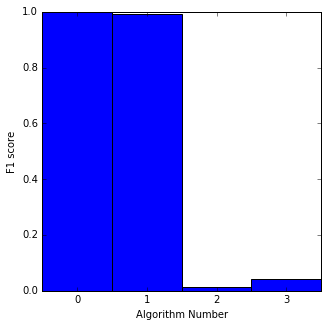

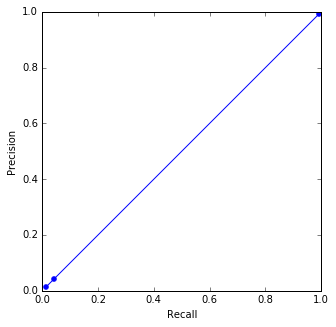

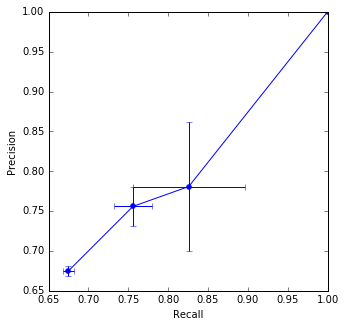

In [7]:
plt.rcParams['figure.figsize'] = (5, 5)
plot_multiple_scores(scores)